# Disaster Tweet Classification: NLP with TensorFlow, spaCy, and BERT

# 1. Introduction

Twitter has shown value as a tool for communicating emergencies in real-time. However, due to figures of speech it is not always clear to a machine when a tweet is about a real disaster. The goal of this exercise is to use natural language processing to build a model that can discern tweets about real disasters from those using figures of speech. The dataset for this task is a collection of 10,000 manually classified tweets (`1` for distaster, `0` for non-disaster) containing keywords, locations, and text. The model selected for this classification is known as Bidirectional Encoder Representations from Transformers ([BERT](https://arxiv.org/abs/1810.04805)). 

Methods for this exercise:
* Text preprocessing and keyword extraction using spaCy
* Loading pre-trained models from TensorFlow Hub
* Building a BERT classifier with the Keras functional API
* Evaluating results with a confusion matrix and ROC curve

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


### 1.1. Install Packages

In [2]:
! python -m pip install tf-models-nightly --no-deps -q
! python -m pip install tf-models-official==2.4.0 -q
! python -m pip install tensorflow-gpu==2.4.1 -q
! python -m pip install tensorflow-text==2.4.1 -q
! python -m spacy download en_core_web_sm -q
! python -m spacy validate 

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-models-nightly 2.5.0.dev20211019 requires sacrebleu, which is not installed.
tf-models-nightly 2.5.0.dev20211019 requires tensorflow-text-nightly, which is not installed.
tf-models-nightly 2.5.0.dev20211019 requires tf-nightly, which is not installed.
tensorflow-gpu 2.4.1 requires gast==0.3.3, but you have gast 0.4.0 which is incompatible.
tensorflow-gpu 2.4.1 requires grpcio~=1.32.0, but you have grpcio 1.41.0 which is incompatible.
tensorflow-gpu 2.4.1 requires h5py~=2.10.0, but you have h5py 3.1.0 which is incompatible.
tensorflow-gpu 2.4.1 requires tensorflow-estimator<2.5.0,>=2.4.0, but you have tensorflow-estimator 2.6.0 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency 

### 1.2. Import Libraries

In [3]:
# Preprocessing
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
import re
import string
from bs4 import BeautifulSoup as bs
# Model Training
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow.keras import layers, Model
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.losses import BinaryCrossentropy
import official.nlp.optimization
from official.nlp.optimization import create_optimizer # AdamW optimizer
from sklearn.metrics import roc_curve, confusion_matrix
# Visualization
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from matplotlib import rcParams
# Version
from platform import python_version

print(f'TensorFlow Version: {tf.__version__}')
print(f'Python Version: {python_version()}')

TensorFlow Version: 2.4.3
Python Version: 3.7.10


### 1.3. Configure Settings

In [4]:
RANDOM_SEED = 123
nlp = spacy.load('en_core_web_sm') 
pd.set_option('display.max_colwidth', None) # Expand DataFrame column width
rcParams['figure.figsize'] = (10, 6) # Custom plot dimensions
sns.set_theme(palette='muted', style='whitegrid') # Seaborn plot theme

### 1.4. Load the Training and Test Files

In [5]:
path = '../input/nlp-getting-started/train.csv'
df = pd.read_csv(path)
print(df.shape)
df.head()

(7613, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [6]:
path_test = '../input/nlp-getting-started/test.csv'
df_test = pd.read_csv(path_test)
print(df_test.shape)
df_test.head()

(3263, 4)


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all"
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


# 2. Raw Data Analysis

We'll use the `info` method to get a summary for the training and test datasets, then we'll use `describe` to get statistics on the text column.

In [7]:
df.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Columns: 5 entries, id to target
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [8]:
df_test.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Columns: 4 entries, id to text
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [9]:
df['text'].describe()

count                                                                                                                                         7613
unique                                                                                                                                        7503
top       11-Year-Old Boy Charged With Manslaughter of Toddler: Report: An 11-year-old boy has been charged with manslaughter over the fatal sh...
freq                                                                                                                                            10
Name: text, dtype: object

In [10]:
df_test['text'].describe()

count                                                                                                                                         3263
unique                                                                                                                                        3243
top       11-Year-Old Boy Charged With Manslaughter of Toddler: Report: An 11-year-old boy has been charged with manslaughter over the fatal sh...
freq                                                                                                                                             3
Name: text, dtype: object

### 2.1. Remove Duplicate Data

It is shown in the descriptive summary that the unique count is less than the total count. This means we could have duplicate data that needs to be dropped for better training results. First we'll look at duplicates that have the same text and target followed by duplicates that share the same keywords and text.

In [11]:
duplicates = df[df.duplicated(['text', 'target'], keep=False)]
print(f'Train Duplicate Entries (text, target): {len(duplicates)}')
duplicates.head()

Train Duplicate Entries (text, target): 157


,id,keyword,location,text,target
40,59,ablaze,Live On Webcam,Check these out: http://t.co/rOI2NSmEJJ http://t.co/3Tj8ZjiN21 http://t.co/YDUiXEfIpE http://t.co/LxTjc87KLS #nsfw,0
48,68,ablaze,Live On Webcam,Check these out: http://t.co/rOI2NSmEJJ http://t.co/3Tj8ZjiN21 http://t.co/YDUiXEfIpE http://t.co/LxTjc87KLS #nsfw,0
106,156,aftershock,US,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vAM5POdGyw | @djicemoon | #Dubstep #TrapMusic #DnB #EDM #Dance #IcesÛ_ http://t.co/zEVakJaPcz,0
115,165,aftershock,US,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vAM5POdGyw | @djicemoon | #Dubstep #TrapMusic #DnB #EDM #Dance #IcesÛ_ http://t.co/zEVakJaPcz,0
118,171,aftershock,Switzerland,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/THyzOMVWU0 | @djicemoon | #Dubstep #TrapMusic #DnB #EDM #Dance #IcesÛ_ http://t.co/83jOO0xk29,0


In [12]:
df.drop_duplicates(['text', 'target'], inplace=True, ignore_index=True)
print(df.shape, df_test.shape)

(7521, 5) (3263, 4)


Duplicates with the same keyword and text share both target classes. The count is low enough to manually review these tweets and drop those with the incorrect target label. 

In [13]:
new_duplicates = df[df.duplicated(['keyword', 'text'], keep=False)]

print(f'Train Duplicate Entries (keyword, text): {len(new_duplicates)}')
new_duplicates[['text', 'target']].sort_values(by='text')

Train Duplicate Entries (keyword, text): 30


,text,target
4238,#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect,0
4253,#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect,1
4171,#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption,1
4193,#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption,0
2802,.POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4,1
2803,.POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4,0
4554,CLEARED:incident with injury:I-495 inner loop Exit 31 - MD 97/Georgia Ave Silver Spring,0
4535,CLEARED:incident with injury:I-495 inner loop Exit 31 - MD 97/Georgia Ave Silver Spring,1
4182,Caution: breathing may be hazardous to your health.,1
4185,Caution: breathing may be hazardous to your health.,0


In [14]:
# Drop the target label that is false for each duplicate pair
df.drop([4253, 4193, 2802, 4554, 4182, 3212, 4249, 4259, 6535, 4319, 4239, 606, 3936, 6018, 5573], inplace=True)

In [15]:
# Reset the dataframe index to account for missing numbers
df = df.reset_index(drop=True)
df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1
...,...,...,...,...,...
7501,10863,NaN,NaN,#WorldNews Fallen powerlines on G:link tram: UPDATE: FIRE crews have evacuated up to 30 passengers who were tr... http://t.co/EYSVvzA7Qm,1
7502,10864,NaN,NaN,on the flip side I'm at Walmart and there is a bomb and everyone had to evacuate so stay tuned if I blow up or not,1
7503,10866,NaN,NaN,Suicide bomber kills 15 in Saudi security site mosque - Reuters via World - Google News - Wall ... http://t.co/nF4IculOje,1
7504,10869,NaN,NaN,Two giant cranes holding a bridge collapse into nearby homes http://t.co/STfMbbZFB5,1


### 2.2. Examine the Target Data Balance

The balance of the target data shows that the minority class makes up just over 40% of the training samples. This is mild enough where we don't need any imbalanced data sampling techinques. 

In [16]:
df['target'].value_counts() / len(df)

0    0.574474
1    0.425526
Name: target, dtype: float64

### 2.3. Check for Null Values

We will check for null values in the training and test data so we can decide how to preprocess it for training and prediction.

In [17]:
def null_table(data): 
    # Bool is True if values are not null
    null_list = []

    for i in data:
        if data[i].notnull().any():
            null_list.append(data[i].notnull().value_counts())
    
    return pd.DataFrame(pd.concat(null_list, axis=1).T)

In [18]:
null_table(df)

,True,False
id,7506.0,NaN
keyword,7450.0,56.0
location,5023.0,2483.0
text,7506.0,NaN
target,7506.0,NaN


In [19]:
null_table(df_test)

,True,False
id,3263.0,NaN
keyword,3237.0,26.0
location,2158.0,1105.0
text,3263.0,NaN


A check for null values in the data shows that the `location` column is missing a significant amount information. This could interfere with model performance, so that data will be excluded. In contrast, the `keyword` column has a more acceptable count of missing values so we can fill these with extracted keywords using spaCy.

# 3. Text Preprocessing and EDA
We'll start by viewing some raw text samples so we can apply the appropriate data cleaning methods. 

In [20]:
text = df['text']
target = df['target']

test_text = df_test['text']

# Print random samples from the training text 
for i in np.random.randint(500, size=5):
    print(f'Tweet #{i}: ', text[i], '=> Target: ', target[i], end='\n' * 2)

Tweet #332:  European Fitba till Christmas  ARMAGEDDON => Target:  0

Tweet #15:  What's up man? => Target:  0

Tweet #242:  U.S National Park Services Tonto National Forest: Stop the Annihilation of the Salt River Wild Horse... http://t.co/6LoJOoROuk via @Change => Target:  0

Tweet #394:  RelaxInPR: miprv: RT latimes: Arson suspect linked to 30 fires caught in Northern California http://t.co/ylhAyfaOOu => Target:  1

Tweet #109:  #GrowingUpSpoiled going clay pigeon shooting and crying because of the 'aftershock' => Target:  0



The next task is to build a text standardization function that is specific to the content found in tweets. Aside from punctuation, there are urls, abbreviations, entities, retweets, digits, stopwords, and of course emojis. The words in each tweet will also be lemmatized or reduced to their root form using the spaCy library. We'll start by building a lookup dictionary with common twitter phrase abbreviations. Tweet terms that match keys in the lookup dictionary will be expanded to their non-abbreviated form.

In [21]:
lookup_dict = {
  'abt' : 'about',
  'afaik' : 'as far as i know',
  'bc' : 'because',
  'bfn' : 'bye for now',
  'bgd' : 'background',
  'bh' : 'blockhead',
  'br' : 'best regards',
  'btw' : 'by the way',
  'cc': 'carbon copy',
  'chk' : 'check',
  'dam' : 'do not annoy me',
  'dd' : 'dear daughter',
  'df': 'dear fiance',
  'ds' : 'dear son',
  'dyk' : 'did you know',
  'em': 'email',
  'ema' : 'email address',
  'ftf' : 'face to face',
  'fb' : 'facebook',
  'ff' : 'follow friday', 
  'fotd' : 'find of the day',
  'ftw': 'for the win',
  'fwiw' : 'for what it is worth',
  'gts' : 'guess the song',
  'hagn' : 'have a good night',
  'hand' : 'have a nice day',
  'hotd' : 'headline of the day',
  'ht' : 'heard through',
  'hth' : 'hope that helps',
  'ic' : 'i see',
  'icymi' : 'in case you missed it',
  'idk' : 'i do not know',
  'ig': 'instagram',
  'iirc' : 'if i remember correctly',
  'imho' : 'in my humble opinion',
  'imo' : 'in my opinion',
  'irl' : 'in real life',
  'iwsn' : 'i want sex now',
  'jk' : 'just kidding',
  'jsyk' : 'just so you know',
  'jv' : 'joint venture',
  'kk' : 'cool cool',
  'kyso' : 'knock your socks off',
  'lmao' : 'laugh my ass off',
  'lmk' : 'let me know', 
  'lo' : 'little one',
  'lol' : 'laugh out loud',
  'mm' : 'music monday',
  'mirl' : 'meet in real life',
  'mrjn' : 'marijuana',
  'nbd' : 'no big deal',
  'nct' : 'nobody cares though',
  'njoy' : 'enjoy',
  'nsfw' : 'not safe for work',
  'nts' : 'note to self',
  'oh' : 'overheard',
  'omg': 'oh my god',
  'oomf' : 'one of my friends',
  'orly' : 'oh really',
  'plmk' : 'please let me know',
  'pnp' : 'party and play', 
  'qotd' : 'quote of the day',
  're' : 'in reply to in regards to',
  'rtq' : 'read the question',
  'rt' : 'retweet',
  'sfw' : 'safe for work',
  'smdh' : 'shaking my damn head', 
  'smh' : 'shaking my head',
  'so' : 'significant other',
  'srs' : 'serious',
  'tftf' : 'thanks for the follow',
  'tftt' : 'thanks for this tweet',
  'tj' : 'tweetjack',
  'tl' : 'timeline',
  'tldr' : 'too long did not read',
  'tmb' : 'tweet me back',
  'tt' : 'trending topic',
  'ty' : 'thank you',
  'tyia' : 'thank you in advance',
  'tyt' : 'take your time',
  'tyvw' : 'thank you very much',
  'w': 'with', 
  'wtv' : 'whatever',
  'ygtr' : 'you got that right',
  'ykwim' : 'you know what i mean',
  'ykyat' : 'you know you are addicted to',
  'ymmv' : 'your mileage may vary',
  'yolo' : 'you only live once',
  'yoyo' : 'you are on your own',
  'yt': 'youtube',
  'yw' : 'you are welcome',
  'zomg' : 'oh my god to the maximum'
}

### 3.1. Text Standardization Functions

In [22]:
def lemmatize_text(text, nlp=nlp):
    doc = nlp(text)    
    lemma_sent = [i.lemma_ for i in doc if not i.is_stop]    
    
    return ' '.join(lemma_sent)  

def abbrev_conversion(text):
    words = text.split() 
    abbrevs_removed = [] 
    
    for i in words:
        if i in lookup_dict:
            i = lookup_dict[i]
        abbrevs_removed.append(i)
            
    return ' '.join(abbrevs_removed)

def standardize_text(text_data):    
    entity_pattern = re.compile(r'(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)') 
    url_pattern = re.compile(r'(?:\@|http?\://|https?\://|www)\S+')
    retweet_pattern = re.compile(r'^(RT|RT:)\s+')
    digit_pattern = re.compile(r'[\d]+')
    # From https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    
    # Remove urls
    url_strip = text_data.apply(lambda x: re.sub(url_pattern, '', x) if pd.isna(x) != True else x)
    # Parse the HTML
    html_parse = url_strip.apply(lambda x: bs(x, 'html.parser').get_text() if pd.isna(x) != True else x)
    # Remove rewteets
    retweet_strip = html_parse.apply(lambda x: re.sub(retweet_pattern, '', x) if pd.isna(x) != True else x)
    # Remove emojis
    emoji_strip = retweet_strip.apply(lambda x: re.sub(emoji_pattern, '', x) if pd.isna(x) != True else x)
    # Remove entities
    entity_strip = emoji_strip.apply(lambda x: re.sub(entity_pattern, '', x) if pd.isna(x) != True else x)
    # Lowercase the strings
    lowercase = entity_strip.apply(lambda x: str.lower(x) if pd.isna(x) != True else x)               
    # Remove punctuation
    punct_strip = lowercase.apply(lambda x: re.sub(f'[{re.escape(string.punctuation)}]', '', x) if pd.isna(x) != True else x) 
    # Convert abbreviations to words
    abbrev_converted = punct_strip.apply(lambda x: abbrev_conversion(x) if pd.isna(x) != True else x)
    # Remove digits
    digit_strip = abbrev_converted.apply(lambda x: re.sub(digit_pattern, '', x) if pd.isna(x) != True else x)    
    # Lemmatize text and filter stopwords
    lemma_and_stop = digit_strip.apply(lambda x: lemmatize_text(x) if pd.isna(x) != True else x)
    
    return lemma_and_stop

In [23]:
clean_text = np.asarray(standardize_text(text))
test_clean_text = np.asarray(standardize_text(test_text))

# Print random samples from the cleaned training text
for i in np.random.randint(500, size=5):
    print(f'Tweet #{i}: ', clean_text[i], '=> Target: ', target[i], end='\n' * 2)

Tweet #294:  know zombie => Target:  0

Tweet #415:  u dick => Target:  0

Tweet #409:  nowplaye arsonist mc significant impressed => Target:  0

Tweet #33:  africanbaze breaking newsnigeria flag set ablaze aba => Target:  1

Tweet #115:  be see issue aftershock => Target:  0



The text is now in a cleaner format for training, but before taking the next step we should explore it with some visualizations.

In [24]:
df['clean_text'] = pd.DataFrame(clean_text)
df_test['clean_text'] = pd.DataFrame(test_clean_text)

### 3.2. Plot Tweet Length Histogram

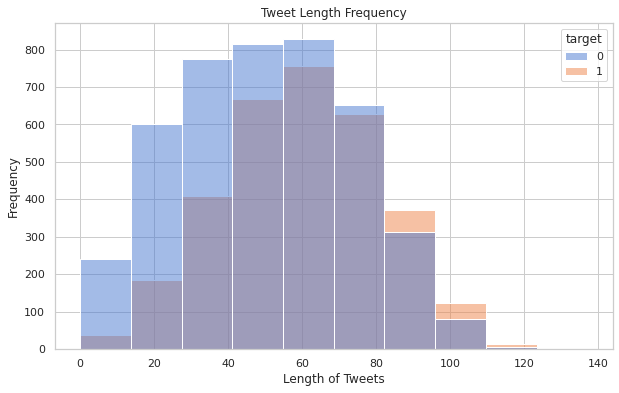

In [25]:
df['tweet_len'] = df['clean_text'].apply(lambda x: len(x))

count, bin_edges = np.histogram(df['tweet_len'])
sns.histplot(data=df, x=df['tweet_len'], bins=bin_edges, hue=df['target'])
plt.title('Tweet Length Frequency')
plt.xlabel('Length of Tweets')
plt.ylabel('Frequency')
plt.show()

A tweet length histogram shows that longer tweets at the end of the distribution have a greater frequency of disaster. 

### 3.3. Display Non-Disaster and Disaster WordClouds

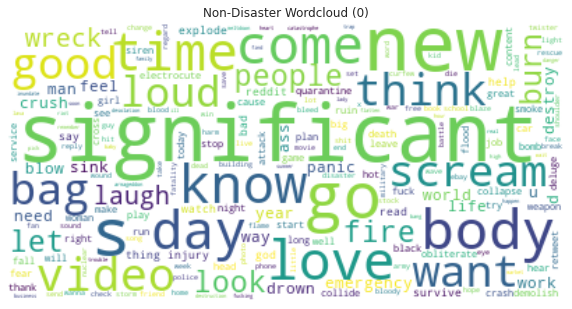

In [26]:
word_cloud_0 = WordCloud(collocations=False, background_color='white').generate(' '.join(df['clean_text'][df['target']==0]))
plt.imshow(word_cloud_0, interpolation='bilinear')
plt.title('Non-Disaster Wordcloud (0)')
plt.axis('off')
plt.show()

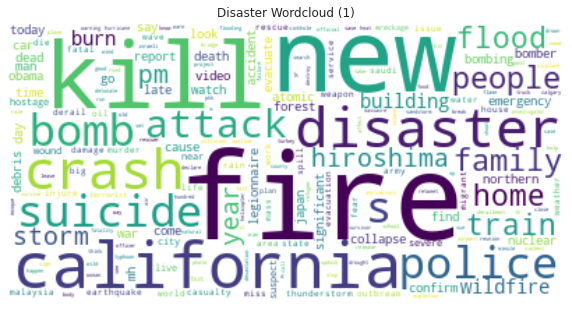

In [27]:
word_cloud_1 = WordCloud(collocations=False, background_color='white').generate(' '.join(df['clean_text'][df['target']==1]))
plt.imshow(word_cloud_1, interpolation='bilinear')
plt.title('Disaster Wordcloud (1)')
plt.axis('off')
plt.show()

### 3.4. Remove the Word *new* from Text

A comparison between disaster and non-disaster wordclouds shows how often different words appear in the tweets. We can see that the word `new` appears quite frequently in both classes, which may add noise to the training process. This term will be dropped altogether so the model can focus on more meaningful words.

In [28]:
pattern_new = re.compile(r'\bnew\b')

print('Training Counts of \'new\': ', len(re.findall(pattern_new, ' '.join(df['clean_text']))))
print('Test Counts of \'new\': ', len(re.findall(pattern_new, ' '.join(df_test['clean_text']))))

Training Counts of 'new':  231
Test Counts of 'new':  106


In [29]:
# Clean the word 'new' from the training and test data
df['clean_text'] = df['clean_text'].apply(lambda x: re.sub(pattern_new, '', x) if pd.isna(x) != True else x)
df_test['clean_text'] = df_test['clean_text'].apply(lambda x: re.sub(pattern_new, '', x) if pd.isna(x) != True else x)

In [30]:
print('Training Counts of \'new\': ', len(re.findall(pattern_new, ' '.join(df['clean_text']))))
print('Test Counts of \'new\': ', len(re.findall(pattern_new, ' '.join(df_test['clean_text']))))

Training Counts of 'new':  0
Test Counts of 'new':  0


### 3.5. Fill Missing Keywords

There are fifty-six missing keywords in the training data set and twenty-six in the test set. We will use spaCy's part of speech tagging feature to fill the missing words. The process is as follows:
1. Create a list of potential keywords by tagging nouns, pronouns, and adjectives
2. Use a sentence encoder to embed the list of potential keywords and the comparison text
3. Calculate vector distances using the cosine similarity function
4. Sort the vectors and select the top keyword for each tweet

The sentence encoder used here is loaded from TensorFlow Hub. It is a pre-trained universal sentence encoder published by Google for use in natural language tasks.

In [31]:
# Load the sentence encoder
sentence_enc = hub.load('https://tfhub.dev/google/universal-sentence-encoder/4')

### 3.6. Keyword Extract and Fill Functions

In [32]:
def extract_keywords(text, nlp=nlp):
    potential_keywords = []
    TOP_KEYWORD = -1
    # Create a list for keyword parts of speech
    pos_tag = ['ADJ', 'NOUN', 'PROPN']
    doc = nlp(text)
    
    for i in doc:
        if i.pos_ in pos_tag:
            potential_keywords.append(i.text)

    document_embed = sentence_enc([text])
    potential_embed = sentence_enc(potential_keywords)    
    
    vector_distances = cosine_similarity(document_embed, potential_embed)
    keyword = [potential_keywords[i] for i in vector_distances.argsort()[0][TOP_KEYWORD:]]

    return keyword

def keyword_filler(keyword, text):
    if pd.isnull(keyword):
        try:
            keyword = extract_keywords(text)[0]
        except:
            keyword = '' 
        
    return keyword

In [33]:
df['keyword_fill'] = pd.DataFrame(list(map(keyword_filler, df['keyword'], df['clean_text']))).astype(str)
df_test['keyword_fill'] = pd.DataFrame(list(map(keyword_filler, df_test['keyword'], df_test['clean_text']))).astype(str)

print('Null Training Keywords => ', df['keyword_fill'].isnull().any())
print('Null Test Keywords => ', df_test['keyword_fill'].isnull().any())

Null Training Keywords =>  False
Null Test Keywords =>  False


Now that the missing keywords are filled we should standardize them to ensure our keywords are clean and ready for training.

In [34]:
df['keyword_fill'] = pd.DataFrame(standardize_text(df['keyword_fill']))
df_test['keyword_fill'] = pd.DataFrame(standardize_text(df_test['keyword_fill']))

In [35]:
df.head()

,id,keyword,location,text,target,clean_text,tweet_len,keyword_fill
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,deed reason earthquake allah forgive,36,earthquake
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,37,forest
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,resident ask shelter place notify officer evacuation shelter place order expect,79,shelter
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1,people receive wildfire evacuation order california,53,wildfire
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,get send photo ruby alaska smoke wildfire pour school,53,wildfire


In [36]:
df_test.head()

,id,keyword,location,text,clean_text,keyword_fill
0,0,NaN,NaN,Just happened a terrible car crash,happen terrible car crash,crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone.",hear earthquake different city stay safe,earthquake
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all",forest fire spot pond goose flee street save,goose
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfire,wildfire
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill china taiwan,taiwan


### 3.7. Plot the Keyword Frequencies 
To learn more about this data column let's visualize the top ten keywords from each target class. 

In [37]:
keyword_count_0 = pd.DataFrame(df['keyword_fill'][df['target']==0].value_counts().reset_index())
keyword_count_1 = pd.DataFrame(df['keyword_fill'][df['target']==1].value_counts().reset_index())

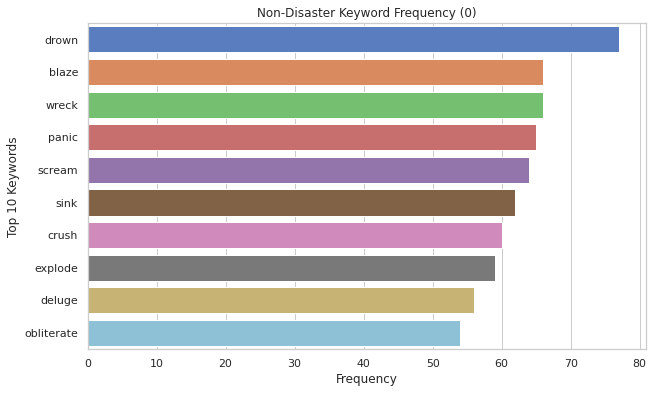

In [38]:
sns.barplot(data=keyword_count_0[:10], x='keyword_fill', y='index')
plt.title('Non-Disaster Keyword Frequency (0)')
plt.xlabel('Frequency')
plt.ylabel('Top 10 Keywords')
plt.show()

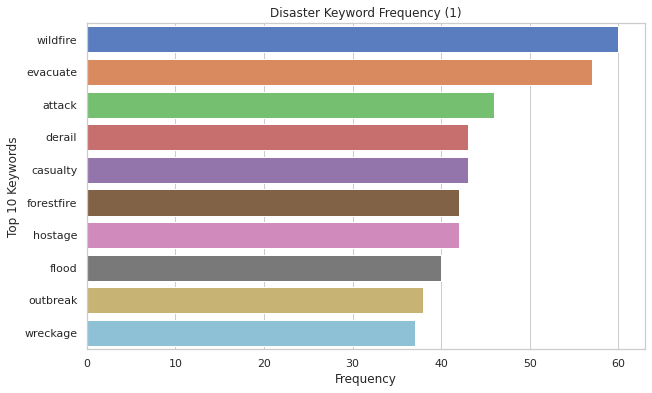

In [39]:
sns.barplot(data=keyword_count_1[:10], x='keyword_fill', y='index')
plt.title('Disaster Keyword Frequency (1)')
plt.xlabel('Frequency')
plt.ylabel('Top 10 Keywords')
plt.show()

A look at the top keywords for each class demonstrates the importance of observing the tweet itself to find context. At a glance, these keywords could belong to either class. That being the case, keywords can still emphasize important parts of speech that may be overlooked by the model. 

# 4. Prepare Data for Training

Our data needs to be prepared for training our model which will receive two inputs, one for text and the other for keywords. Our approach is to select the `clean_text` and `keyword_fill` columns before splitting the data into training and validation sets.

### 4.1. Select the Clean Text and Filled Keyword Columns

In [40]:
train_features = df[['clean_text','keyword_fill']]
test_features = df_test[['clean_text', 'keyword_fill']]

In [41]:
train_features[:5]

,clean_text,keyword_fill
0,deed reason earthquake allah forgive,earthquake
1,forest fire near la ronge sask canada,forest
2,resident ask shelter place notify officer evacuation shelter place order expect,shelter
3,people receive wildfire evacuation order california,wildfire
4,get send photo ruby alaska smoke wildfire pour school,wildfire


In [42]:
test_features[:5]

,clean_text,keyword_fill
0,happen terrible car crash,crash
1,hear earthquake different city stay safe,earthquake
2,forest fire spot pond goose flee street save,goose
3,apocalypse lighting spokane wildfire,wildfire
4,typhoon soudelor kill china taiwan,taiwan


In [43]:
print(train_features.shape)
print(test_features.shape)

(7506, 2)
(3263, 2)


### 4.2. Create Data Splits
A training split is produced leaving 20% of the data for validation purposes. 

In [44]:
train_x, val_x, train_y, val_y = train_test_split(
    train_features,
    target,
    test_size=0.2,
    random_state=RANDOM_SEED,
)

print(train_x.shape)
print(train_y.shape)
print(val_x.shape)
print(val_y.shape)

(6004, 2)
(6004,)
(1502, 2)
(1502,)


### 4.3. Create TensorFlow Datasets

We'll form these data splits into TensorFlow Datasets and configure them before building our model. Include the features as dictionaries so they can be selectively processed by our model.

In [45]:
# Create TensorFlow Datasets 
train_ds = tf.data.Dataset.from_tensor_slices((dict(train_x), train_y))
val_ds = tf.data.Dataset.from_tensor_slices((dict(val_x), val_y))
test_ds = tf.data.Dataset.from_tensor_slices(dict(test_features))

In [46]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

BUFFER_SIZE = 1000
BATCH_SIZE = 32

def configure_dataset(dataset, shuffle=False, test=False):
    # Configure the tf dataset for cache, shuffle, batch, and prefetch
    if shuffle:
        dataset = dataset.cache()\
                        .shuffle(BUFFER_SIZE, seed=RANDOM_SEED, reshuffle_each_iteration=True)\
                        .batch(BATCH_SIZE, drop_remainder=True).prefetch(AUTOTUNE)
    elif test:
        dataset = dataset.cache()\
                        .batch(BATCH_SIZE, drop_remainder=False).prefetch(AUTOTUNE)
    else:
        dataset = dataset.cache()\
                        .batch(BATCH_SIZE, drop_remainder=True).prefetch(AUTOTUNE)
    return dataset

In [47]:
# Configure the datasets
train_ds = configure_dataset(train_ds, shuffle=True)
val_ds = configure_dataset(val_ds)
test_ds = configure_dataset(test_ds, test=True)

In [48]:
# Print the dataset specifications
print(train_ds.element_spec)
print(val_ds.element_spec)
print(test_ds.element_spec)

({'clean_text': TensorSpec(shape=(32,), dtype=tf.string, name=None), 'keyword_fill': TensorSpec(shape=(32,), dtype=tf.string, name=None)}, TensorSpec(shape=(32,), dtype=tf.int64, name=None))
({'clean_text': TensorSpec(shape=(32,), dtype=tf.string, name=None), 'keyword_fill': TensorSpec(shape=(32,), dtype=tf.string, name=None)}, TensorSpec(shape=(32,), dtype=tf.int64, name=None))
{'clean_text': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'keyword_fill': TensorSpec(shape=(None,), dtype=tf.string, name=None)}


# 5. Building the Classifier Model

For this task we will be using a pre-trained BERT model loaded from TensorFlow Hub. This model has 12 hidden layers, a hidden unit size of 768, and 12 attention heads. It has a companion preprocessor that is loaded from the same repository. This preprocessor takes text segments and converts them to numeric token ids accepted by the BERT encoder. These token ids are:
* input_word_ids
    - ids of the input sequences
* input_mask
    - represents all pre-padded input tokens as 1, and padded tokens as 0
* input_type_ids
    - contains indices for each input segment with padding locations indexed at 0

### 5.1. Load the Pre-trained BERT Encoder 

In [49]:
# BERT encoder w/ preprocessor
bert_preprocessor = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3', name='BERT_preprocesser')
bert_encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4', trainable=True, name='BERT_encoder')
# Keyword embedding layer
nnlm_embed = hub.KerasLayer('https://tfhub.dev/google/nnlm-en-dim50/2', name='embedding_layer')

### 5.2. Model Composition

To build our classifier we will be using the TensorFlow functional API, this will reduce constraints on our model design. Two input branches will be merged into a classification layer. The first branch is a text input layer that feeds into the BERT preprocessor. This layer is passed to the BERT encoder and is returned as a pooled output. This output is then regularized with a dropout layer. 

On the second branch, a keyword input is passed to a pre-trained word embedding layer. The embeddings are flattened and passed into a dense neural net, then fed into a dropout layer. 

The layer outputs from each model are concatenated, passed into a dense neural net with dropout, then sent to a single unit dense classification layer with a sigmoid activation. The sigmoid activation function will return class probabilities that we can use to plot a Receiver Operating Characteristic ([ROC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)) curve and a [Confusion Matrix](https://en.wikipedia.org/wiki/Confusion_matrix) to analyze our results. 

In [50]:
def build_model():
    
    # Construct text layers
    text_input = layers.Input(shape=(), dtype=tf.string, name='clean_text') # Name matches df heading
    encoder_inputs = bert_preprocessor(text_input)
    encoder_outputs = bert_encoder(encoder_inputs)
    # pooled_output returns [batch_size, hidden_layers]
    pooled_output = encoder_outputs["pooled_output"]          
    bert_dropout = layers.Dropout(0.1, name='BERT_dropout')(pooled_output)   
    
    # Construct keyword layers
    key_input = layers.Input(shape=(), dtype=tf.string, name='keyword_fill') # Name matches df heading
    key_embed = nnlm_embed(key_input)
    key_flat = layers.Flatten()(key_embed)
    key_dense = layers.Dense(128, activation='elu', kernel_regularizer=regularizers.l2(1e-4))(key_flat)
    key_dropout = layers.Dropout(0.5, name='dense_dropout')(key_dense)
    
    # Merge the layers and classify 
    merge = layers.concatenate([bert_dropout, key_dropout])
    dense = layers.Dense(128, activation='elu', kernel_regularizer=regularizers.l2(1e-4))(merge)
    dropout = layers.Dropout(0.5, name='merged_dropout')(dense)    
    clf = layers.Dense(1, activation='sigmoid', name='classifier')(dropout)

    return Model([text_input, key_input], clf, name='BERT_classifier')

In [51]:
bert_classifier = build_model()
bert_classifier.summary()

Model: "BERT_classifier"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
keyword_fill (InputLayer)       [(None,)]            0                                            
__________________________________________________________________________________________________
clean_text (InputLayer)         [(None,)]            0                                            
__________________________________________________________________________________________________
embedding_layer (KerasLayer)    (None, 50)           48190600    keyword_fill[0][0]               
__________________________________________________________________________________________________
BERT_preprocesser (KerasLayer)  {'input_type_ids': ( 0           clean_text[0][0]                 
____________________________________________________________________________________

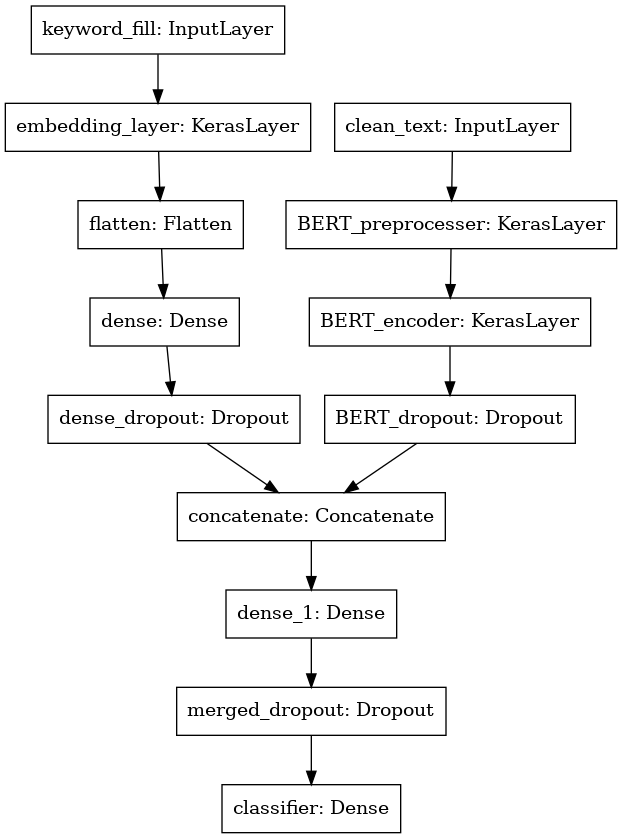

In [52]:
tf.keras.utils.plot_model(bert_classifier, show_shapes=False, dpi=96)

For training the BERT model we'll use an Adam optimizer with weight decay ([AdamW](https://arxiv.org/abs/1711.05101)). This method differs from the standard Adam algorithm with its use of decoupled weight decay regularization. This is the optimizer that BERT was originally trained with. It has a linear warm-up period over the first 10% of training steps paired with a lower learning rate. One of the simpler ways to implement this [optimizer](https://github.com/tensorflow/models/blob/master/official/nlp/optimization.py) is with the TensorFlow official models collection.

### 5.3. Construct the AdamW Optimizer

In [53]:
EPOCHS = 2
LEARNING_RATE = 5e-5

STEPS_PER_EPOCH = int(train_ds.unbatch().cardinality().numpy() / BATCH_SIZE)
VAL_STEPS = int(val_ds.unbatch().cardinality().numpy() / BATCH_SIZE)
# Calculate the train and warmup steps for the optimizer
TRAIN_STEPS = STEPS_PER_EPOCH * EPOCHS
WARMUP_STEPS = int(TRAIN_STEPS * 0.1)

adamw_optimizer = create_optimizer(
    init_lr=LEARNING_RATE,
    num_train_steps=TRAIN_STEPS,
    num_warmup_steps=WARMUP_STEPS
)

# 6. Train the Classifier
This is a classification problem with two labels, so we'll compile with a binary crossentropy loss function and a binary accuracy metric with our optimizer. Included are the previously calculated `steps_per_epoch` and `validation_steps`.

In [54]:
bert_classifier.compile(
    loss=BinaryCrossentropy(from_logits=True), 
    optimizer= adamw_optimizer,
    metrics=[BinaryAccuracy(name='accuracy')]
)

history = bert_classifier.fit(
    train_ds, 
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,    
    validation_data= val_ds,
    validation_steps=VAL_STEPS
)

Epoch 1/2
187/187 [==============================] - 128s 589ms/step - loss: 0.6789 - accuracy: 0.6518 - val_loss: 0.4546 - val_accuracy: 0.8159
Epoch 2/2
187/187 [==============================] - 109s 580ms/step - loss: 0.4187 - accuracy: 0.8430 - val_loss: 0.4801 - val_accuracy: 0.8240


# 7. Visualize Results

Now that the model has been trained, we will plot the accuracy and loss metrics for the training and validation data.   

### 7.1. Plot the Loss and Accuracy Metrics

In [55]:
# Assign the loss and accuracy metrics
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

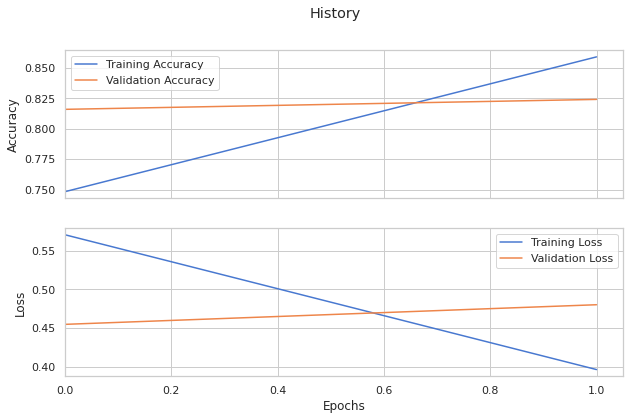

In [56]:
# Plot the training and validation metrics
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
sns.lineplot(ax=ax1, data = train_acc, label=f'Training Accuracy')
sns.lineplot(ax=ax1, data = val_acc, label=f'Validation Accuracy')
sns.lineplot(ax=ax2, data = train_loss, label=f'Training Loss')
sns.lineplot(ax=ax2, data = val_loss, label=f'Validation Loss')
ax1.set_ylabel('Accuracy')
ax1.set_xlim(xmin=0)
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epochs')
ax2.set_xlim(xmin=0)
plt.suptitle('History')
plt.show()

### 7.2. Plot the ROC Curve

Another graphical method we'll use is the Receiver Operating Characteristic curve ([ROC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)). It plots the true positive rate against the false positive rate at different classification thresholds to visualize the predictive ability of the model. Curves skewed towards the upper left corner of the plot reflect models with good performance as opposed to near linear curves which indicate poor performance.

In [57]:
# Get the array of labels from the validation Dataset
val_target = np.asarray([i[1] for i in list(val_ds.unbatch().as_numpy_iterator())])
print(val_target.shape)
val_target[:5]

(1472,)


array([1, 0, 0, 0, 1])

In [58]:
# Get predictions from the validation Dataset
val_predict = bert_classifier.predict(val_ds)

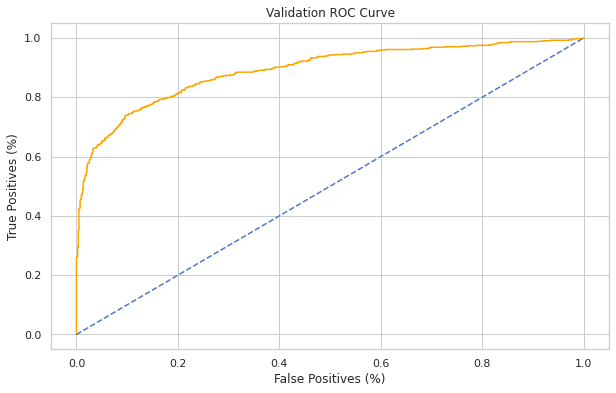

In [59]:
# Get the false positive and true positive rates
fpr, tpr, _ = roc_curve(val_target, val_predict)
plt.plot(fpr, tpr, color='orange')
plt.plot([0,1], [0,1], linestyle='--')
plt.title('Validation ROC Curve')
plt.xlabel('False Positives (%)')
plt.ylabel('True Positives (%)')
plt.grid(True)    
plt.show()

### 7.3. Plot the Confusion Matrix

A confusion matrix will compare the predicted values with the actual data from the validation set. This is interpreted through the use of true and false positives versus true and false negatives. A model that performs well will maximize true rates while minimizing false rates. A false positive is known as a Type 1 error and a false negative is known as a Type 2 error.

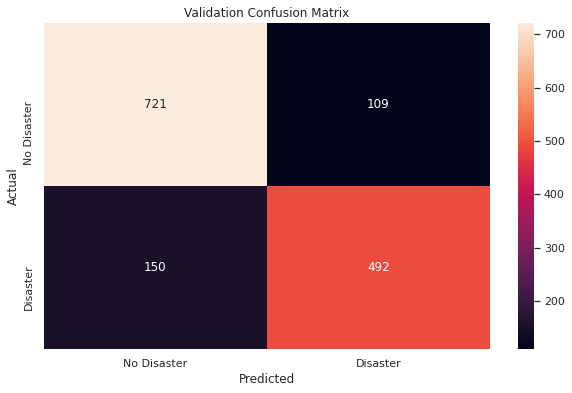

In [60]:
THRESHOLD = 0.5 # Default value
# Get the true negative, false positive, false negative, and true positive values
tn, fp, fn, tp = confusion_matrix(val_target, val_predict > THRESHOLD).flatten()
# Construct the dataframe
cm = pd.DataFrame(
                    [[tn, fp], [fn, tp]], 
                    index=['No Disaster', 'Disaster'], 
                    columns=['No Disaster', 'Disaster']
)
# Plot the matrix
sns.heatmap(cm, annot=True, fmt='g')    
plt.title('Validation Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# 8. Predictions on the Test Data

Now that we have our ideal threshold value, let's go ahead and make predictions with our classifier. We'll receive an array of probabilities that we can then use to plot a histogram of our results and graph the threshold value.

In [61]:
predictions = bert_classifier.predict(test_ds)
print(predictions.shape)
print(predictions[:5])

(3263, 1)
[[0.97504514]
 [0.9891082 ]
 [0.99105096]
 [0.99682885]
 [0.9965084 ]]


### 8.1. Predictions Histogram

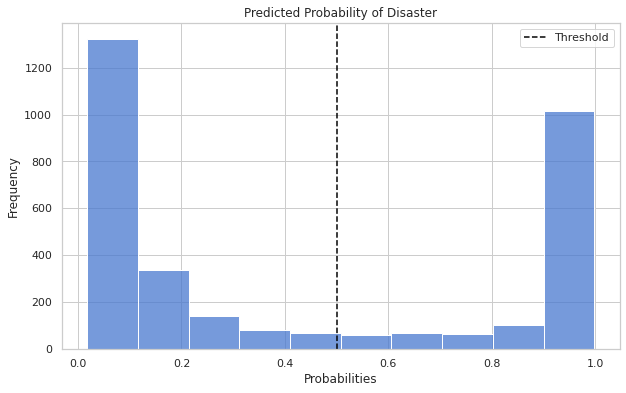

In [62]:
count, bin_edges = np.histogram(predictions)
sns.histplot(predictions, bins=bin_edges, legend=False)
plt.axvline(x=THRESHOLD, linestyle='--', color='black', label='Threshold')
plt.title('Predicted Probability of Disaster')
plt.xlabel('Probabilities')
plt.ylabel('Frequency')
plt.legend()
plt.show()

This distribution represents the binary nature of the prediction values. The threshold marks the line by which predictions will be considered either non-disasters (below threshold) or disasters (above threshold). The default value for a binary accuracy threshold is `0.5`. Finally we use this threshold to label and submit the predictions.

### 8.2. Label the Predictions

In [63]:
# Use the threshold to label predictions
predictions = np.where(predictions > THRESHOLD, 1, 0)
df_predictions = pd.DataFrame(predictions)
df_predictions.columns = ['target']

print(df_predictions.shape)
df_predictions.head()

(3263, 1)


,target
0,1
1,1
2,1
3,1
4,1


### 8.3. Submit the Predictions

In [64]:
# Concatenate the columns and convert submission to csv
submission = pd.concat([df_test['id'], df_predictions], axis=1)
submission.to_csv('submission.csv', index=False)